In [28]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFilter
from PIL import Image
from tqdm import tqdm
import random

In [11]:
zip_file_path = 'imagefolder.zip'
extraction_folder = 'imagefolder_extracted'

In [12]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)


In [13]:
image_folder = extraction_folder
classes = os.listdir(image_folder)

In [14]:
num_classes = len(classes)
print(f"Number of classes: {num_classes}")


Number of classes: 1


In [15]:
class_distribution = {class_name: len(os.listdir(os.path.join(image_folder, class_name))) for class_name in classes}
print("Distribution of images across classes:")
print(class_distribution)

Distribution of images across classes:
{'imagefolder': 18}


In [16]:
balanced = len(set(class_distribution.values())) == 1
print(f"Are the classes balanced? {balanced}")

Are the classes balanced? True


In [17]:
total_num_images = sum(class_distribution.values())
print(f"Total number of images: {total_num_images}")

Total number of images: 18


In [18]:
image_dimensions = []
for class_name in classes:
    class_path = os.path.join(image_folder, class_name)
    for filename in os.listdir(class_path):
        filepath = os.path.join(class_path, filename)
        with Image.open(filepath) as img:
            width, height = img.size
            image_dimensions.append((width, height))

In [19]:
unique_dimensions = set(image_dimensions)
uniform_dimensions = len(unique_dimensions) == 1
print(f"Are the dimensions uniform? {uniform_dimensions} ({unique_dimensions})")


Are the dimensions uniform? False ({(500, 791), (500, 566), (500, 749), (500, 678), (500, 578), (500, 597), (500, 575), (500, 616), (500, 613), (500, 625), (500, 564), (534, 500), (562, 500), (500, 612), (666, 500)})


In [20]:
aspect_ratios = [width / height for width, height in image_dimensions]
print("Most common aspect ratios:", set(aspect_ratios))


Most common aspect ratios: {0.8650519031141869, 1.332, 0.6321112515802781, 0.8156606851549756, 0.8116883116883117, 0.8, 0.7374631268436578, 0.6675567423230975, 0.8865248226950354, 0.8833922261484098, 1.068, 1.124, 0.8375209380234506, 0.8695652173913043, 0.8169934640522876}


In [21]:
total_size = sum(os.path.getsize(os.path.join(image_folder, class_name, filename))
                 for class_name in classes for filename in os.listdir(os.path.join(image_folder, class_name)))
average_size = total_size / total_num_images / 1024  # in KB
print(f"Average size of images: {average_size:.2f} KB")


Average size of images: 35.75 KB


In [23]:
duplicate_images = set()
for class_name in classes:
    class_path = os.path.join(image_folder, class_name)
    for filename in os.listdir(class_path):
        filepath = os.path.join(class_path, filename)
        img_hash = hash(Image.open(filepath).tobytes())
        if img_hash in duplicate_images:
            print(f"Duplicate image found: {filename}")
        else:
            duplicate_images.add(img_hash)

In [24]:
corrupted_images = []
for class_name in classes:
    class_path = os.path.join(image_folder, class_name)
    for filename in os.listdir(class_path):
        filepath = os.path.join(class_path, filename)
        try:
            with Image.open(filepath) as img:
                img.verify()  # Checking image integrity
        except Exception as e:
            print(f"Corrupted image detected: {filename}, Error: {str(e)}")
            corrupted_images.append(filename)


In [31]:
def calculate_image_properties(image_path):
    img = Image.open(image_path)
    img_np = np.array(img)

    brightness = np.mean(img_np)  # Average brightness
    contrast = np.std(img_np)      # Standard deviation for contrast

    # Apply a kernel filter to measure sharpness
    sharpness_filter = ImageFilter.Kernel(
        size=(3, 3),
        kernel=[-1, -1, -1, -1, 9, -1, -1, -1, -1],
        scale=None,
        offset=0
    )
    
    # Convert image to grayscale for sharpness detection
    img_gray = img.convert("L")
    
    # Apply the filter to the image
    sharpness_image = img_gray.filter(sharpness_filter)
    sharpness_np = np.array(sharpness_image)

    # Measure sharpness by calculating the standard deviation of the filtered image
    sharpness = np.std(sharpness_np)

    return brightness / 255, contrast, sharpness / 255 
metadata = []
for class_name in classes:
    class_path = os.path.join(image_folder, class_name)
    for filename in os.listdir(class_path):
        filepath = os.path.join(class_path, filename)
        brightness, contrast, sharpness = calculate_image_properties(filepath)
        metadata.append((brightness, contrast, sharpness))

avg_brightness = np.mean([m[0] for m in metadata])
avg_contrast = np.mean([m[1] for m in metadata])
avg_sharpness = np.mean([m[2] for m in metadata])
print(f"Average Brightness: {avg_brightness}, Average Contrast: {avg_contrast}, Average Sharpness: {avg_sharpness}")

Average Brightness: 0.33289123266765636, Average Contrast: 73.17142511757184, Average Sharpness: 0.29884559999843424


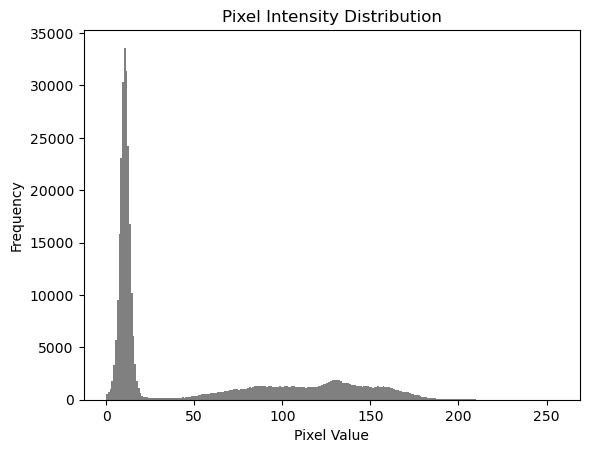

In [37]:
def visualize_pixel_intensity(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_np = np.array(img)

    plt.hist(img_np.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Ensure classes is defined and has elements
if len(classes) > 2:
    # Randomly select two classes
    selected_classes = random.sample(classes, 2)
else:
    selected_classes = classes  # Or handle the case however you prefer

# Show histogram for a few sample images
for class_name in selected_classes:
    class_path = os.path.join(image_folder, class_name)
    
    # Ensure there's at least one image in this class
    if os.listdir(class_path):
        filepath = os.path.join(class_path, random.choice(os.listdir(class_path)))
        visualize_pixel_intensity(filepath)
    else:
        print(f"No images found in {class_path}")

In [39]:
def downsample_image(image_path):
    img = Image.open(image_path)
    img_resized = img.resize((32, 32))
    img_resized.show()

# Ensure classes is defined and has elements
if len(classes) >= 2:  # Check if there are enough classes to sample
    selected_classes = random.sample(classes, 2)
else:
    selected_classes = classes  # Use all available classes

# Show downsampled images
for class_name in selected_classes:
    class_path = os.path.join(image_folder, class_name)

    # Ensure there's at least one image in the class directory
    if os.listdir(class_path):
        filepath = os.path.join(class_path, random.choice(os.listdir(class_path)))
        downsample_image(filepath)
    else:
        print(f"No images found in {class_path}")

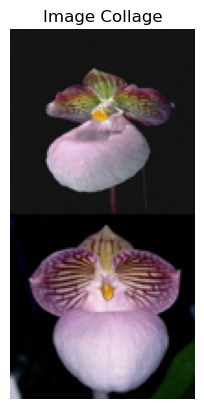

In [42]:
def create_collage(num_classes, num_images_per_class):
    collage_images = []
    
    # Ensure there are enough classes to sample
    available_classes = min(num_classes, len(classes))
    
    for _ in range(num_images_per_class):
        for class_name in random.sample(classes, available_classes):  # Use the number of available classes
            class_path = os.path.join(image_folder, class_name)
            
            # Ensure there's at least one image in the class directory before sampling
            if os.listdir(class_path):
                filepath = os.path.join(class_path, random.choice(os.listdir(class_path)))
                img = Image.open(filepath).resize((100, 100))  # Resizing for collage
                collage_images.append(np.array(img))
            else:
                print(f"No images found in {class_path}")

    # Create the collage if there are enough images
    if collage_images:
        try:
            collage = np.vstack([np.hstack(collage_images[i:i + available_classes]) for i in range(0, len(collage_images), available_classes)])
            plt.imshow(collage)
            plt.axis('off')
            plt.title('Image Collage')
            plt.show()
        except ValueError as e:
            print(f"Error creating collage: {e}")
    else:
        print("No images were collected for the collage.")

# Create and show a collage
create_collage(num_classes=3, num_images_per_class=2)

In [44]:
def augment_image(image_path):
    img = Image.open(image_path)
    # Rotation
    rotated = img.rotate(90)  # Rotate 90 degrees
    rotated.show()

    # Flipping
    flipped = img.transpose(Image.FLIP_LEFT_RIGHT)  # Horizontal flip
    flipped.show()

def show_augmented_images(num_samples):
    # Ensure there are at least as many samples as specified
    num_classes = min(num_samples, len(classes))
    
    for _ in range(num_samples):
        selected_classes = random.sample(classes, num_classes)
        
        # Select at least one class from the available classes
        classes_used = [class_name for class_name in selected_classes if os.listdir(os.path.join(image_folder, class_name))] or selected_classes[0]
        
        for class_name in random.sample(classes_used, num_classes):
            filepath = os.path.join(image_folder, class_name, random.choice(os.listdir(os.path.join(image_folder, class_name))))
            augment_image(filepath)

# Show augmented images for a few samples
show_augmented_images(num_samples=2)